Dataset Used: https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords
import re
import emoji
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()
import time as t
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import pickle

In [2]:
#Preprocessing the text
def preprocessing(text):
    text = text.lower()#converting text to lowercase
    text = emoji.demojize(text,delimiters=(" "," "))#converting emojis to words
    text = re.sub(r'@\S+', '', text)#removing user tags
    text = re.sub(r'http\S+', '', text)#removing website links (starting with http or https)
    text = re.sub(r'www\S+', '', text)#removing website links (starting with www.)
    text = re.sub(r'#\S+', '', text)#removing hashtags
    text = re.sub("[^a-zA-Z]", " ",text)#removing everything except english alphabets
    text = " ".join([i for i in text.split() if i not in stopwords.words("english")])#removing the stopwords
    return text

In [3]:
twitter_data = pd.read_csv("Twitter_Data.csv")#Reading the dataset

In [4]:
print("Total Number of Documents in Original Dataset:",len(twitter_data))

Total Number of Documents in Original Dataset: 162980


In [5]:
#first 10 rows of the dataset
twitter_data.head(10)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace f...,0.0
7,this comes from cabinet which has scholars lik...,0.0
8,with upcoming election india saga going import...,1.0
9,gandhi was gay does modi,1.0


In [6]:
#checking for null values
twitter_data.isna().sum()

clean_text    4
category      7
dtype: int64

In [7]:
#removing all the rows containing null value
twitter_data_new = twitter_data.dropna()

In [8]:
print("Total Number of Documents:",len(twitter_data_new))

Total Number of Documents: 162969


In [9]:
#preprocessing the text data and since the values in category contain negative, we add 1 to all the values 
twitter_data_new["clean_text"] = twitter_data_new["clean_text"].progress_apply(preprocessing)
twitter_data_new["category"]+=1

100%|█████████████████████████████████████████████████████████████████████████| 162969/162969 [09:54<00:00, 274.09it/s]


(array([35509., 55211., 72249.]),
 array([0, 1, 2, 3]),
 <BarContainer object of 3 artists>)

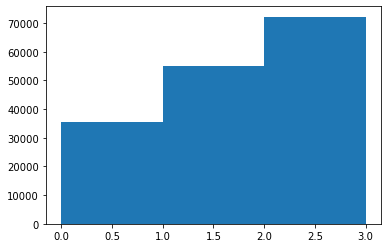

In [10]:
#overall class distribution for the given dataset
plt.hist(twitter_data_new["category"],bins=[0,1,2,3])

In [11]:
#Using tfidf vectorizer for text representation (using word as analyzer)
vec = TfidfVectorizer(ngram_range=(1,5),max_features=1000)

In [12]:
#using train test split to split the data into train and test data(Not validation)
X_train_text,X_test_text,Y_train,Y_test = train_test_split(twitter_data_new["clean_text"],
                                                           twitter_data_new["category"],test_size=0.2,random_state=42)

In [13]:
#Converting text to vector
X_train = vec.fit_transform(X_train_text)
X_test = vec.transform(X_test_text)

(array([28357., 44144., 57874.]),
 array([0, 1, 2, 3]),
 <BarContainer object of 3 artists>)

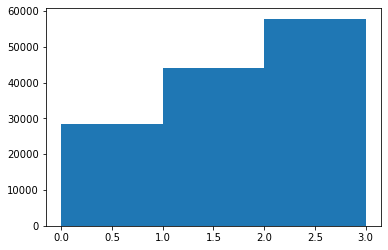

In [14]:
#overall class distribution for the test data
#Note: Since the classes are not highly imbalanced, Using SMOTE is not entertained
plt.hist(Y_train,bins=[0,1,2,3])

In [15]:
#Hyperparameter tuning using GridSearchCV, using default 5-fold cross validation
#parameters for XGBClassifier
parameters = {"booster":('dart','gbtree'),
              "max_depth":(5,6,7),
              "n_estimators":(100,200),
             "gpu_id":[0]}
xgb_clf = XGBClassifier()

clf = GridSearchCV(xgb_clf, parameters,scoring='accuracy',verbose=10)
st = t.time()
clf.fit(X_train,Y_train)
print("Time Taken:",t.time()-st)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START booster=dart, gpu_id=0, max_depth=5, n_estimators=100......
[CV 1/5; 1/12] END booster=dart, gpu_id=0, max_depth=5, n_estimators=100;, score=0.775 total time= 1.1min
[CV 2/5; 1/12] START booster=dart, gpu_id=0, max_depth=5, n_estimators=100......
[CV 2/5; 1/12] END booster=dart, gpu_id=0, max_depth=5, n_estimators=100;, score=0.780 total time= 1.2min
[CV 3/5; 1/12] START booster=dart, gpu_id=0, max_depth=5, n_estimators=100......
[CV 3/5; 1/12] END booster=dart, gpu_id=0, max_depth=5, n_estimators=100;, score=0.783 total time= 1.2min
[CV 4/5; 1/12] START booster=dart, gpu_id=0, max_depth=5, n_estimators=100......
[CV 4/5; 1/12] END booster=dart, gpu_id=0, max_depth=5, n_estimators=100;, score=0.783 total time= 1.3min
[CV 5/5; 1/12] START booster=dart, gpu_id=0, max_depth=5, n_estimators=100......
[CV 5/5; 1/12] END booster=dart, gpu_id=0, max_depth=5, n_estimators=100;, score=0.785 total time= 1.3min
[CV 

[CV 4/5; 9/12] END booster=gbtree, gpu_id=0, max_depth=6, n_estimators=100;, score=0.785 total time=  19.0s
[CV 5/5; 9/12] START booster=gbtree, gpu_id=0, max_depth=6, n_estimators=100....
[CV 5/5; 9/12] END booster=gbtree, gpu_id=0, max_depth=6, n_estimators=100;, score=0.785 total time=  18.9s
[CV 1/5; 10/12] START booster=gbtree, gpu_id=0, max_depth=6, n_estimators=200...
[CV 1/5; 10/12] END booster=gbtree, gpu_id=0, max_depth=6, n_estimators=200;, score=0.777 total time=  38.4s
[CV 2/5; 10/12] START booster=gbtree, gpu_id=0, max_depth=6, n_estimators=200...
[CV 2/5; 10/12] END booster=gbtree, gpu_id=0, max_depth=6, n_estimators=200;, score=0.783 total time=  38.3s
[CV 3/5; 10/12] START booster=gbtree, gpu_id=0, max_depth=6, n_estimators=200...
[CV 3/5; 10/12] END booster=gbtree, gpu_id=0, max_depth=6, n_estimators=200;, score=0.785 total time=  38.4s
[CV 4/5; 10/12] START booster=gbtree, gpu_id=0, max_depth=6, n_estimators=200...
[CV 4/5; 10/12] END booster=gbtree, gpu_id=0, max_de

In [16]:
test_preds = clf.predict(X_test) #testing the model

In [17]:
print(classification_report(Y_test,test_preds)) #performance of the model on test data

              precision    recall  f1-score   support

         0.0       0.83      0.54      0.65      7152
         1.0       0.69      0.98      0.81     11067
         2.0       0.90      0.76      0.82     14375

    accuracy                           0.79     32594
   macro avg       0.80      0.76      0.76     32594
weighted avg       0.81      0.79      0.78     32594



In [18]:
filename = 'final_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [25]:
def test_new_text(new_text,model):
    text = preprocessing(new_text)
    print(text)
    text_rep = vec.transform([text])
    return model.predict(text_rep)-1

In [26]:
import pickle
model = pickle.load(open('final_model.sav', 'rb'))

In [28]:
test_new_text(input("Enter the text:"),model)

Enter the text:#movie was so great I loved it
great loved


array([1], dtype=int64)